In [ ]:
pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score

In [ ]:
!mkdir data
!wget https://raw.githubusercontent.com/tvoloshin/technoatom_ML/main/Homework_3/data/Test.csv -O ./data/Test.csv
!wget https://raw.githubusercontent.com/tvoloshin/technoatom_ML/main/Homework_3/data/Train.csv -O ./data/Train.csv
!wget https://raw.githubusercontent.com/tvoloshin/technoatom_ML/main/Homework_3/data/SampleSubmission.csv -O ./data/SampleSubmission.csv

--2021-06-01 14:31:53--  https://raw.githubusercontent.com/tvoloshin/technoatom_ML/main/Homework_3/data/Test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6608738 (6.3M) [text/plain]
Saving to: ‘./data/Test.csv’

./data/Test.csv     100%[===================>]   6.30M  29.5MB/s    in 0.2s    

2021-06-01 14:31:54 (29.5 MB/s) - ‘./data/Test.csv’ saved [6608738/6608738]

--2021-06-01 14:31:54--  https://raw.githubusercontent.com/tvoloshin/technoatom_ML/main/Homework_3/data/Train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

# Работа с данными

In [ ]:
train = pd.read_csv('./data/Train.csv')
test = pd.read_csv('./data/Test.csv')

In [ ]:
pd.set_option('display.max_columns', 18)

In [ ]:
train.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,...,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,2011-1,385,NaN,1,59,3,0,25.0,...,0,0,0,0,0,0,0,0,2489000
1,1,2011-1,247,NaN,5,53,2,1,15.0,...,0,0,0,0,0,0,0,0,1995000
2,2,2011-1,115,0.0,7,61,3,0,10.0,...,0,0,0,0,0,0,0,0,3993000
3,3,2011-1,491,1.0,5,61,3,1,30.0,...,0,0,0,0,0,0,0,0,5709000
4,4,2011-1,623,NaN,3,51,2,1,30.0,...,0,0,0,0,0,0,0,0,4374000


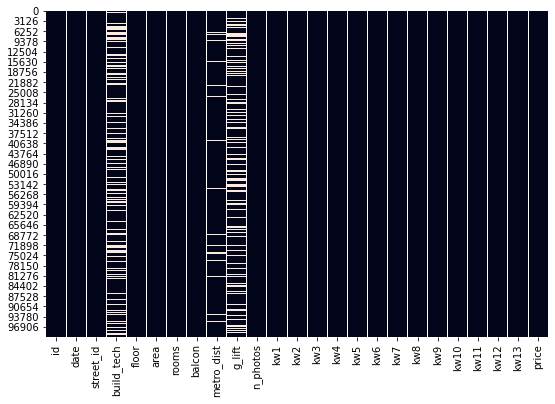

In [ ]:
# Поссмотрим пропущенные значения
plt.figure(figsize=(9, 6)) 
sns.heatmap(train.isnull(), cbar=False);

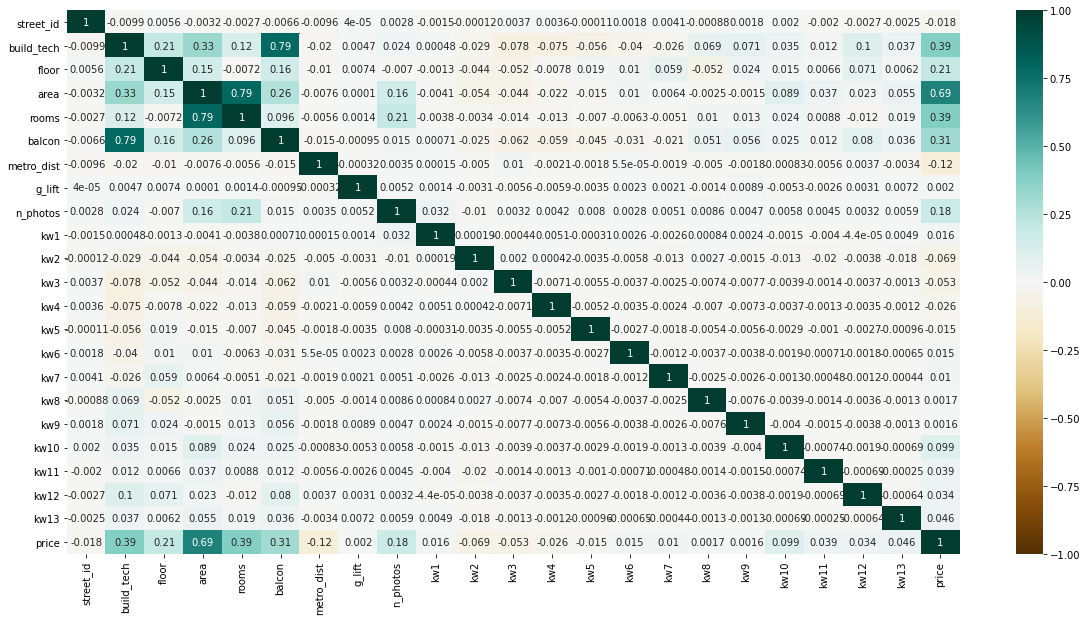

In [ ]:
# Построим матрицу корреляций
plt.figure(figsize=(20, 10)) 
heatmap = sns.heatmap(train.iloc[:, 2:].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

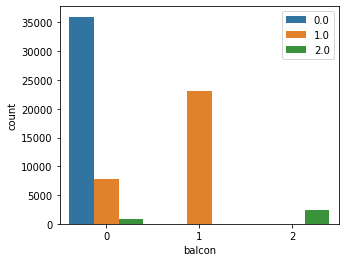

In [ ]:
# Признаки 'balcon' и 'build_tech' коррелируют - посмотрим их связь
plt.figure(figsize=(5, 4));
sns.countplot(x='balcon', hue='build_tech', data=train);
plt.legend(loc='upper right');

In [ ]:
# Заполним пропущенные значения 'build_tech' в соответствии с 'balcon'
train.loc[train.build_tech.isnull(), 'build_tech'] = train.loc[train.build_tech.isnull(), 'balcon']

# Признак 'g_lift' слабо влияет на цену - удалим его
del train['g_lift']

# Расстояние до метро заполним средним значением для соответствующей улицы
average_dist = train['street_id'].map(train.groupby('street_id')['metro_dist'].mean())
train['metro_dist'] = train['metro_dist'].fillna(average_dist)

In [ ]:
X = train.iloc[:, 2:-1]
y = train.iloc[:, -1]

In [ ]:
mae = make_scorer(mean_absolute_error)

# Простые модели (не используются в итоге)

In [ ]:
LR = LinearRegression()

cross_val_score(LR, X, y, scoring=mae).mean()

1631071.9216982687

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
LR_poly = Pipeline([
                    ('poly', PolynomialFeatures(2, interaction_only=False)),
                    ('lr', LinearRegression())
])

cross_val_score(LR_poly, X, y, scoring=mae).mean()

1595540.1894234815

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso()

cross_val_score(lasso, X, y, scoring=mae).mean()

1631071.5772487312

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=6)

cross_val_score(neigh, X, y, scoring=mae).mean()

1488737.09

In [ ]:
from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor()

cross_val_score(DT, X, y, scoring=mae).mean()

1724687.2150000003

In [ ]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(n_estimators=100)

cross_val_score(RF, X, y, scoring=mae).mean()

1320885.8755909526

In [ ]:
from sklearn.linear_model import SGDRegressor

columns_to_scale = ['street_id', 'area', 'metro_dist', 'n_photos', 'rooms', 'floor', 'build_tech', 'balcon']
SGD = Pipeline([
                ('preprocessing', ColumnTransformer([('scale', StandardScaler(), columns_to_scale)])),
                ('SGD', SGDRegressor(random_state=42))
])

cross_val_score(SGD, X, y, scoring=mae).mean()

1636317.0158142191

In [ ]:
from sklearn.ensemble import StackingRegressor
LR_poly_stack = Pipeline([
                          ('poly', PolynomialFeatures(3, interaction_only=True)),
                          ('lr', LinearRegression())
                          ])

estimators = [
              ('neigh', neigh),
              ('sgd', SGD),
              ('tree', DT),
              ('linear', lasso)
              ]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=LR_poly_stack,
    passthrough=False
    )

cross_val_score(stack, X, y, scoring=mae).mean()

1388032.5499576845

In [ ]:
VR = VotingRegressor(estimators=[('stacking', stack), ('forest', RF)])

cross_val_score(VR, X, y, scoring=mae).mean()

1314445.0285162386

# GradientBoosting (sklearn)

In [ ]:
gb = GradientBoostingRegressor(n_estimators=200,
                               learning_rate=0.49,
                               min_samples_split=5,
                               init=LinearRegression(),
                               random_state=42,
                               max_depth=8)

cross_val_score(base_gb, X, y, scoring=mae, cv=3).mean()

In [ ]:
gb_bagging = BaggingRegressor(base_estimator=gb,
                              n_estimators=5,
                              n_jobs=-1,
                              random_state=42)

cross_val_score(gb_bagging, X, y, scoring=mae, cv=3).mean()

761681.4805966103

# XGBoost

In [ ]:
xgb = XGBRegressor(n_estimators=200,
                   learning_rate=.5,
                   max_depth=8,
                   eval_metric='mae',
                   silent=True)

cross_val_score(xgb, X, y, scoring=mae, cv=4).mean()

785747.8860900195

In [ ]:
VR = VotingRegressor(estimators=[('xgb', xgb), ('sklearn_gb', gb)])

cross_val_score(VR, X, y, scoring=mae, cv=2).mean()

778960.5751579377

# Итоговая модель

In [ ]:
# Два бэггинга из разных реализаций градиентного бустинга (sklearn и xgboost), результат - по их голосованию
sklearn_bagging = BaggingRegressor(base_estimator=gb,
                                   n_estimators=45,
                                   max_samples=.9)

xgb_bagging = BaggingRegressor(base_estimator=xgb,
                               n_estimators=45,
                               max_samples=.9)

gb_voting = VotingRegressor(estimators=[('xgb', xgb_bagging), ('sklearn_gb', sklearn_bagging)])

# cross_val_score(gb_voting, X, y, scoring=mae, cv=2).mean()

In [ ]:
test = pd.read_csv('./data/Test.csv')

del test['g_lift']

average_dist = test['street_id'].map(test.groupby('street_id')['metro_dist'].mean())
test['metro_dist'] = test['metro_dist'].fillna(average_dist)

test.loc[test.build_tech.isnull(), 'build_tech'] = test.loc[test.build_tech.isnull(), 'balcon']

In [ ]:
final = gb_voting
final.fit(X, y)
predict = final.predict(test.iloc[:, 2:])

predict_ = pd.concat([test.iloc[:, 0], pd.Series(predict, name='price')], axis=1)
predict_.to_csv('predict.csv', index=False)